# OPS!
Now you have to considere wich years will constitude your testset. Tree will serve nicely: 2015, 2016, 2017. But if you have the time it would be nice to also estimate with the full set so you can test on 2018 when it come out.

2017 came out around mid 2018. Thus for any pratical use the framework need to be evaluated 2-3 three years into the furture.

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import pandas as pd
import geopandas as gpd

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwd

# Do the data:

In [2]:
# get data:

def get_data():

    pkl_file = open('full_df.pkl', 'rb')

    df = pickle.load(pkl_file)

    pkl_file.close()
    
    y_north_limit = 50
    y_south_limit = - 10
    x_east_limit = 100
    x_west_limit  = -20
    
    df_sub = df[(df['ycoord'] > y_south_limit)&(df['ycoord'] < y_north_limit)&(df['xcoord']<x_east_limit)&(df['xcoord']>x_west_limit)]
    
    years = np.sort(df['year'].unique())
    
    data = []
    
    for i, j in enumerate(years):
        
        # Data from Prio and UCDP
        df_sub_year = df_sub[df_sub['year']==j]
        X = np.array([df_sub_year['xcoord'], df_sub_year['ycoord']])
        
#         # for spares estimation - better do this out of loop.
#         sub1 = df_sub_year[df_sub_year['best']>0]
#         Xu = np.array([sub1['xcoord'], sub1['ycoord']]).T
        
        # Data from spatial estimation
        file_name = 'spatial_est_{}.pkl'.format(j)
    
        pkl_file = open(file_name, 'rb')

        estimates = pickle.load(pkl_file)

        pkl_file.close()
        
        year_array = np.zeros(X.shape[1]) + j
        
        data.append(np.dstack([estimates['mu'],estimates['var'],X[0],X[1],year_array])[0,:,:]) # to get rid of a spare dim...

    concat_data = np.concatenate(data)
    
    df_new = pd.DataFrame(concat_data, columns= ['mu','var','xcoord','ycoord','year'])        
    df_full = df_sub.merge(df_new, on = ['xcoord','ycoord','year'], how = 'outer')
    
    return(df_full)

In [3]:
df = get_data()
test_df = df[df['year']>=2015].sort_values(['gid','year'])
train_df =  df[df['year']<2015].sort_values(['gid','year'])

In [4]:
def get_X_new(step_size = 0.25):
    step = step_size
    min_year = df['year'].min()
    max_year = df['year'].max()

    X_new = np.arange(min_year,max_year + step, step)
    
    return(X_new)

In [80]:
# X and y and index
X = np.array(train_df['year'])[:,None]
y = np.array(train_df['mu'])
index = np.array(train_df['gid'])

# subset for map est:
gid_list = np.random.choice(df[df['mu']>1]['gid'].unique(),100) # random non zeores. Fungere godt med 100..
# train_df_sub = train_df.sample(100)
train_df_sub = train_df[train_df['gid'].isin(gid_list)].sort_values(['gid','year'])

X1 = np.array(train_df_sub['year'])[:,None]
y1 = np.array(train_df_sub['mu'])
index1 = np.array(train_df_sub['gid'])

# New X.
X_new = get_X_new()

In [81]:
X_new = X_new[:,None]

In [6]:
# regarding wheter to clip sub zero estimates, whait and se waht happens when your split the long term and yearly component from each other.

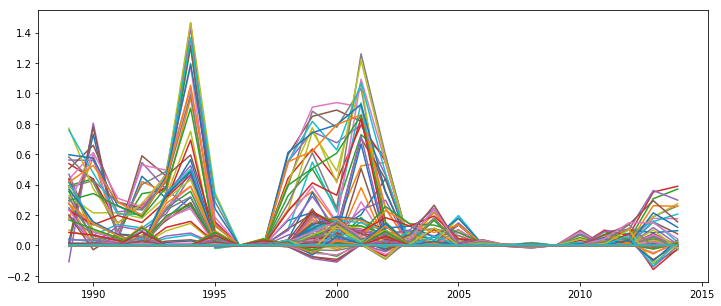

In [28]:


fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index)[0:100]):
    plt.plot(X[index == j], y[index==j])
    
plt.show()



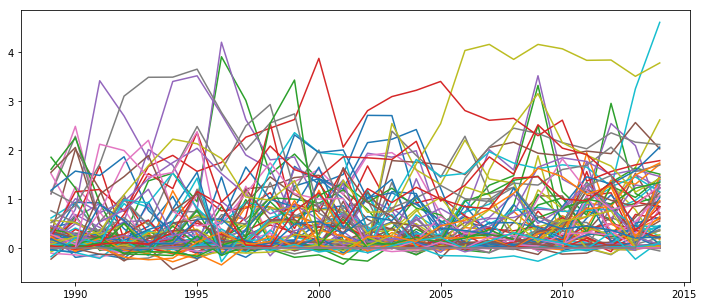

In [82]:
fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index1)[0:100]):
    plt.plot(X1[index1 == j], y1[index1==j])
    
plt.show()

# Estimation

### Illustrate priors:

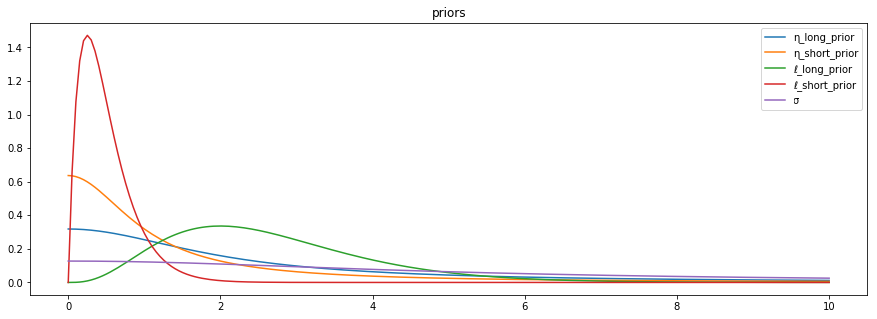

In [8]:
grid = np.linspace(0,10,200)
priors = [
    ('η_long_prior', pm.HalfCauchy.dist(beta=2)),
    ('η_short_prior', pm.HalfCauchy.dist(beta=1)),
    ('ℓ_long_prior', pm.Gamma.dist(alpha=4, beta=1.5)),
    ('ℓ_short_prior', pm.Gamma.dist(alpha=2, beta=4)),
    ('σ', pm.HalfCauchy.dist(beta=5))]

plt.figure(figsize= [15,5])
plt.title('priors')


for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.legend()
plt.show()

### The model
So you need to find uot if you should get map from only a subset of X. Like all with more then two years of bieng near a conflcit.
you can also tyr the sparse implimentation.

# sample for map est:
two components

In [83]:
# step0

time0 = time.time()

with pm.Model() as model:
    
    # long term trend
    ℓ_long = pm.Gamma("ℓ_long", alpha=4, beta=1.5, shape = 1)
    η_long = pm.HalfCauchy("η_long", beta=2, shape = 1)
    
    #short term trend
    ℓ_short = pm.Gamma("ℓ_short", alpha=2, beta=4, shape = 1)
    η_short = pm.HalfCauchy("η_short", beta=1, shape = 1)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=5, shape = 1)
    
    # sample to fit map: 
    gp_list = []
    gp_long_list = []
    gp_short_list = []

    for i, j in enumerate(np.unique(index1)):
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
#         mean = pm.gp.mean.Constant(0)
        
        cov_long = η_long **2 * pm.gp.cov.ExpQuad(1, ℓ_long)
        cov_short = η_short ** 2 * pm.gp.cov.ExpQuad(1, ℓ_short )         
        
        gp_long = pm.gp.Marginal(cov_func=cov_long)
        gp_short = pm.gp.Marginal(cov_func=cov_short)

        gp = gp_long + gp_short
        
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X1[index1 == j], y=y1[index1 == j], noise= σ)
        
        gp_list.append(gp)
        gp_long_list.append(gp_long)
        gp_short_list.append(gp_short)

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [84]:
#step1

time1 = time.time()

with model:
    mp = pm.find_MAP()

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `ar

In [85]:
time2 = time.time()
step0t = (time1 - time0)/60
step1t = (time2 - time1)/60

stepallt = (time2 - time0)/60

print('step 0: {}min \n step 1: {} \n time total: {}min'.format(step0t, step1t, stepallt))

step 0: 1.0444082140922546min 
 step 1: 13.31911739508311 
 time total: 14.363525609175364min


In [86]:
mp

{'η_long': array([0.69907691]),
 'η_long_log__': array([-0.35799452]),
 'η_short': array([0.35542795]),
 'η_short_log__': array([-1.03443272]),
 'σ': array([0.00128811]),
 'σ_log__': array([-6.65458118]),
 'ℓ_long': array([4.39331651]),
 'ℓ_long_log__': array([1.48008441]),
 'ℓ_short': array([0.56763432]),
 'ℓ_short_log__': array([-0.56627787])}

# Prediction

In [96]:
time_0 = time.time()

mu_list = []
var_list = []
mu_long_list = []
var_long_list = []
mu_short_list = []
var_short_list = []

for i, j in enumerate(np.unique(index1)):
    mu, var = gp_list[i].predict(X_new, point=mp, 
                                 diag=True)
    
    # It does apparently not matter wich gp from gp_list you use. As suspected.
    mu_long, var_long = gp_long_list[i].predict(X_new, point=mp,
                                      given = {'gp' : gp_list[0], 'X' : X1[index1 == j], 'y' : y1[index1 == j], 'noise' : σ },
                                      diag=True)
    
    
    mu_short, var_short = gp_short_list[i].predict(X_new, point=mp,
                                      given = {'gp' : gp_list[0], 'X' : X1[index1 == j], 'y' : y1[index1 == j], 'noise' : σ },
                                      diag=True)
    
    
    mu_list.append(mu)
    var_list.append(var)
    
    mu_long_list.append(mu_long)
    var_long_list.append(var_long)
    
    mu_short_list.append(mu_short)
    var_short_list.append(var_short)
    
    print('{}/{}'.format(i,np.unique(index1).shape[0]), end = '-')
    
    
time_1 = time.time()


time_step1 = (time_1 - time_0)/60

print('total {}min'.format(time_step1))

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


0/98-1/98-2/98-3/98-4/98-5/98-6/98-7/98-8/98-9/98-10/98-11/98-12/98-13/98-14/98-15/98-16/98-17/98-18/98-19/98-20/98-21/98-22/98-23/98-24/98-25/98-26/98-27/98-28/98-29/98-30/98-31/98-32/98-33/98-34/98-35/98-36/98-37/98-38/98-39/98-40/98-41/98-42/98-43/98-44/98-45/98-46/98-47/98-48/98-49/98-50/98-51/98-52/98-53/98-54/98-55/98-56/98-57/98-58/98-59/98-60/98-61/98-62/98-63/98-64/98-65/98-66/98-67/98-68/98-69/98-70/98-71/98-72/98-73/98-74/98-75/98-76/98-77/98-78/98-79/98-80/98-81/98-82/98-83/98-84/98-85/98-86/98-87/98-88/98-89/98-90/98-91/98-92/98-93/98-94/98-95/98-96/98-97/98-total 7.8465496818224585min


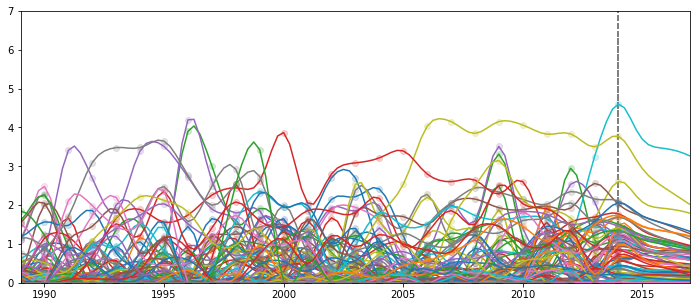

In [97]:
fig = plt.figure(figsize=(12,5))

start = 0
end = 100

for i, j in enumerate(np.unique(index1)[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(X_new, mu_list[i], color = color)
    plt.plot(X1[index1 == j], y1[index1 == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X1.max(),0,y1.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X1.max()))



plt.ylim(0,7)
plt.xlim(X_new.min(),X_new.max())
plt.show()

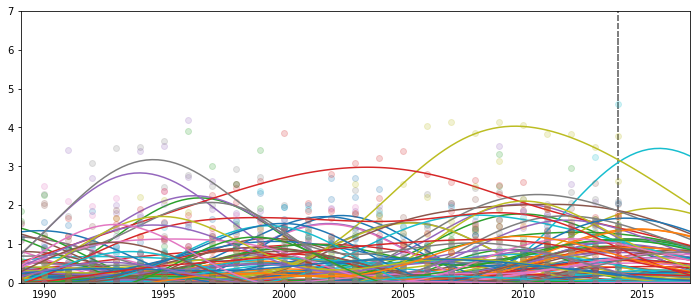

In [98]:
fig = plt.figure(figsize=(12,5))    

for i, j in enumerate(np.unique(index1)[start:end]):
    i = i + start

    color = 'C' + str(i)[-1] # reiterates after 9

    plt.plot(X_new, mu_long_list[i], color = color)
    plt.plot(X1[index1 == j], y1[index1 == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X1.max(),0,y1.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))

plt.ylim(0,7)
plt.xlim(X_new.min(),X_new.max())

plt.show()

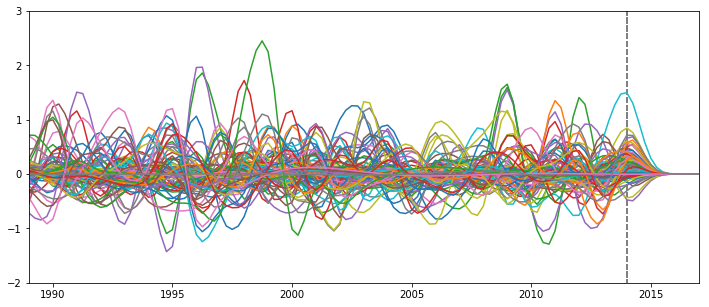

In [99]:
fig = plt.figure(figsize=(12,5))
    
for i, j in enumerate(np.unique(index1)[start:end]):
    i = i + start

    color = 'C' + str(i)[-1] # reiterates after 9

    plt.plot(X_new, mu_short_list[i], color = color)
    plt.vlines(X1.max(),-y1.max()*2,y1.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))


plt.ylim(-2,3)
plt.xlim(X_new.min(),X_new.max())

plt.show()

Så nu er spørgsmålet om du også kan køre nyt x og y ind. Det burde du.

# With different gps from gp litst

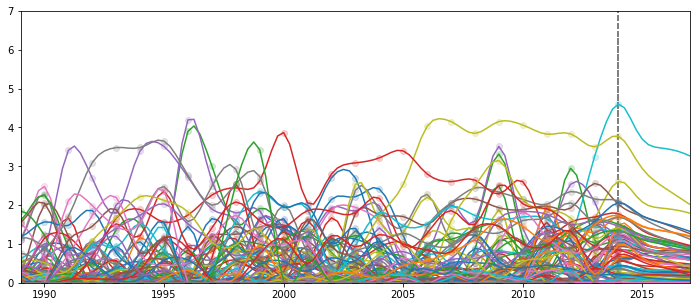

In [93]:
fig = plt.figure(figsize=(12,5))

start = 0
end = 100

for i, j in enumerate(np.unique(index1)[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(X_new, mu_list[i], color = color)
    plt.plot(X1[index1 == j], y1[index1 == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X1.max(),0,y1.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X1.max()))



plt.ylim(0,7)
plt.xlim(X_new.min(),X_new.max())
plt.show()

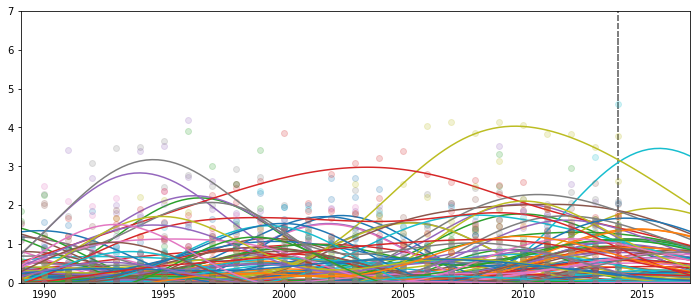

In [94]:
fig = plt.figure(figsize=(12,5))    

for i, j in enumerate(np.unique(index1)[start:end]):
    i = i + start

    color = 'C' + str(i)[-1] # reiterates after 9

    plt.plot(X_new, mu_long_list[i], color = color)
    plt.plot(X1[index1 == j], y1[index1 == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X1.max(),0,y1.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))

plt.ylim(0,7)
plt.xlim(X_new.min(),X_new.max())

plt.show()

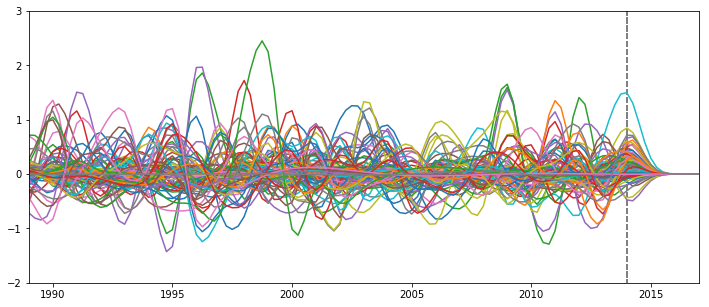

In [95]:
fig = plt.figure(figsize=(12,5))
    
for i, j in enumerate(np.unique(index1)[start:end]):
    i = i + start

    color = 'C' + str(i)[-1] # reiterates after 9

    plt.plot(X_new, mu_short_list[i], color = color)
    plt.vlines(X1.max(),-y1.max()*2,y1.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))


plt.ylim(-2,3)
plt.xlim(X_new.min(),X_new.max())

plt.show()

# Old:

In [ ]:
# step0

time0 = time.time()

with pm.Model() as model:
    
    # long term trend
    ℓ_long = pm.Gamma("ℓ_long", alpha=4, beta=1.5, shape = 1)
    η_long = pm.HalfCauchy("η_long", beta=2, shape = 1)
    
    #short term trend
    ℓ_short = pm.Gamma("ℓ_short", alpha=2, beta=4, shape = 1)
    η_short = pm.HalfCauchy("η_short", beta=1, shape = 1)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=5, shape = 1)
    
    # sample to fit map: 
    gp_list = []
    gp_long_list = []
    gp_short_list = []

    for i, j in enumerate(np.unique(index)[0:100]):
        
        Xu = np.array(train_df[(train_df['mu']>0)&(train_df['gid']==index[0])]['year'])[:, None] # men der er jo obs hvert år...
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
#         mean = pm.gp.mean.Constant(0)
        
        cov_long = η_long **2 * pm.gp.cov.ExpQuad(1, ℓ_long)
        cov_short = η_short ** 2 * pm.gp.cov.ExpQuad(1, ℓ_short )         
        
        gp_long = pm.gp.MarginalSparse(cov_func=cov_long)
        gp_short = pm.gp.MarginalSparse(cov_func=cov_short)

        gp = gp_long + gp_short
        
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X[index == j], y=y[index == j], Xu = Xu, noise= σ)
        
        gp_list.append(gp)
        gp_long_list.append(gp_long)
        gp_short_list.append(gp_short)